# Python for data science

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

## Preparing the data

Load telemetry data from .csv file.

In [2]:
telemetry = pd.read_csv('../data/telemetry.csv', names=['cups', 'date', 'time', 'value'], parse_dates=['date'])
telemetry.head()

,cups,date,time,value
0,ES0022000008101283SA,2015-01-30,7,3
1,ES0022000008101283SA,2015-01-30,9,10
2,ES0022000008101283SA,2015-01-30,11,25
3,ES0022000008101283SA,2015-01-30,5,3
4,ES0022000008101283SA,2015-01-30,1,3


Remove the weekends. Who needs weekends anyway?

In [3]:
weekdays = telemetry['date'].dt.weekday < 5
telemetry = telemetry[weekdays]

Calculate average consumption for every hour.

In [4]:
telemetry = telemetry.groupby(['cups', 'time'])['value'].mean()

Scale consumption values.

In [5]:
cups_total = telemetry.sum(level='cups')
telemetry = telemetry.unstack('time').div(cups_total, axis='index')

Show what we have now.

In [6]:
pd.set_option('precision', 3)  # Just makes things easier to read
telemetry.head()

time,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
cups,,,,,,,,,,,,,,,,,,,,,
ES0021000000196751TY,0.05,0.07,0.08,0.07,0.07,0.07,0.07,0.07,0.07,0.03,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.03,0.03,0.03
ES0021000000367440SN,0.02,0.05,0.08,0.08,0.08,0.08,0.08,0.08,0.06,0.03,...,0.02,0.02,0.02,0.02,0.02,0.03,0.03,0.03,0.03,0.03
ES0021000000470891MD,0.02,0.02,0.02,0.01,0.01,0.01,0.02,0.04,0.07,0.08,...,0.09,0.09,0.05,0.02,0.02,0.02,0.02,0.02,0.02,0.02
ES0021000000516885GA,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.07,...,0.06,0.03,0.04,0.05,0.06,0.05,0.03,0.03,0.03,0.03
ES0021000000584383VL,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.08,0.07,0.05,...,0.05,0.04,0.04,0.05,0.05,0.06,0.06,0.07,0.06,0.02


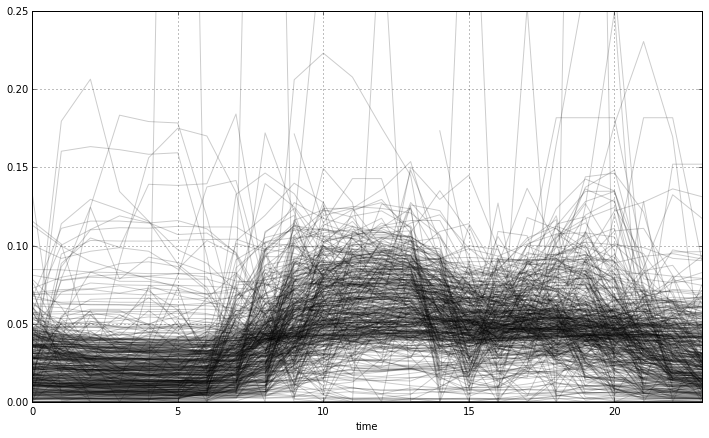

In [7]:
lim = (0, 0.25)
telemetry.transpose().plot(color='k', alpha=0.2, ylim=lim, legend=False, figsize=(12, 7));

## Clustering

In [8]:
from sklearn import cluster

k = 4
clt = cluster.SpectralClustering(n_clusters=k, random_state=0)
X = telemetry.fillna(0).values
clt.fit(X)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver=None, eigen_tol=0.0, gamma=1.0, kernel_params=None,
          n_clusters=4, n_init=10, n_neighbors=10, random_state=0)

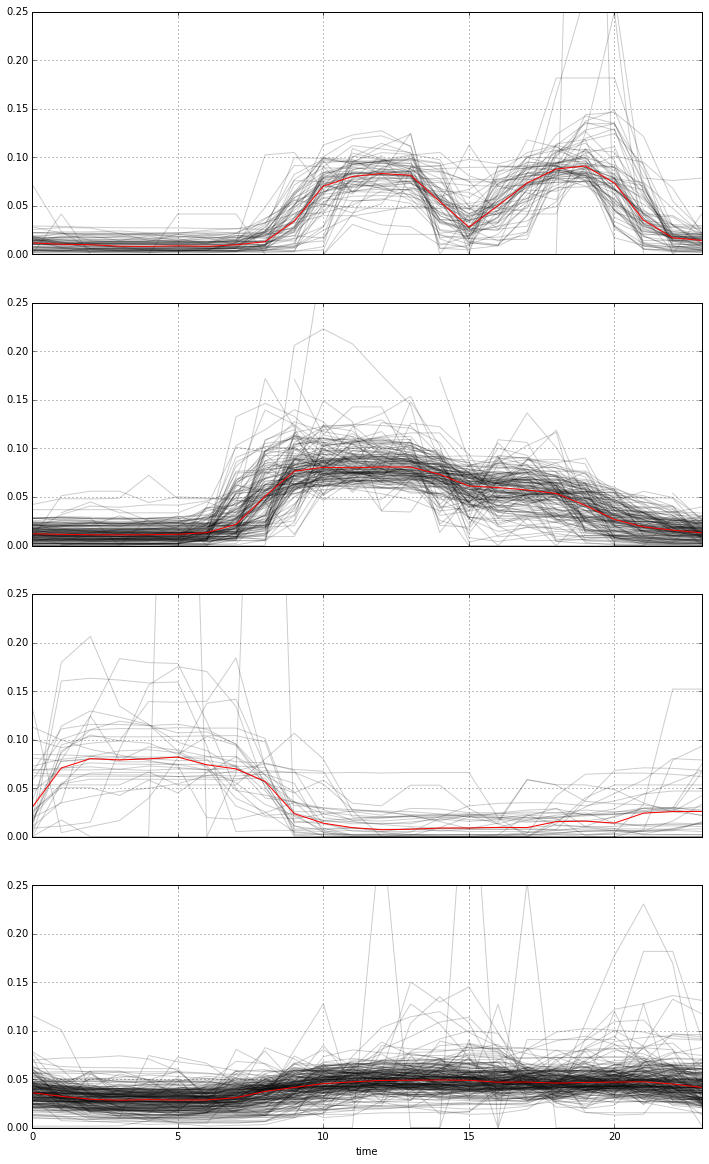

In [9]:
fig, axes = plt.subplots(nrows=k, ncols=1, figsize=(12, 20))

for i in range(k):
    telemetry[clt.labels_ == i].transpose().plot(color='k', ylim=lim, alpha=0.2, legend=False, ax=axes[i])
    telemetry[clt.labels_ == i].median().plot(color='r', ylim=lim, ax=axes[i])

## Running R code

In [10]:
%load_ext rpy2.ipython

Just to be clear... I have no idea what I'm doing.

In [11]:
%Rpush X
%R print(lm(X[,13]~X[,14])$coef)
%R print(lm(X[,13]~X[,23])$coef)

(Intercept)     X[, 14] 
0.009076755 0.854978543 


(Intercept)     X[, 23] 
 0.07864643 -0.54684417 


 All abroad the R'oflcopter! Let's use libraries and make plots! Cool stuff!

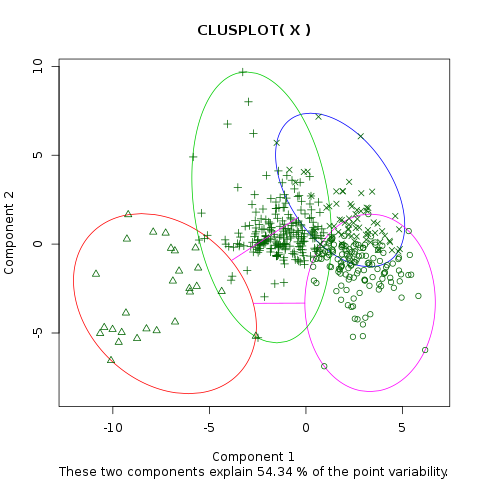

In [12]:
%%R -i k -o rlabels

# This is R code! you can tell by the artsy indentation and the fugly arrows...
library(cluster)

fit <- kmeans(X, k)
 clusplot(X, fit$cluster, color=TRUE)
  rlabels <- fit$cluster

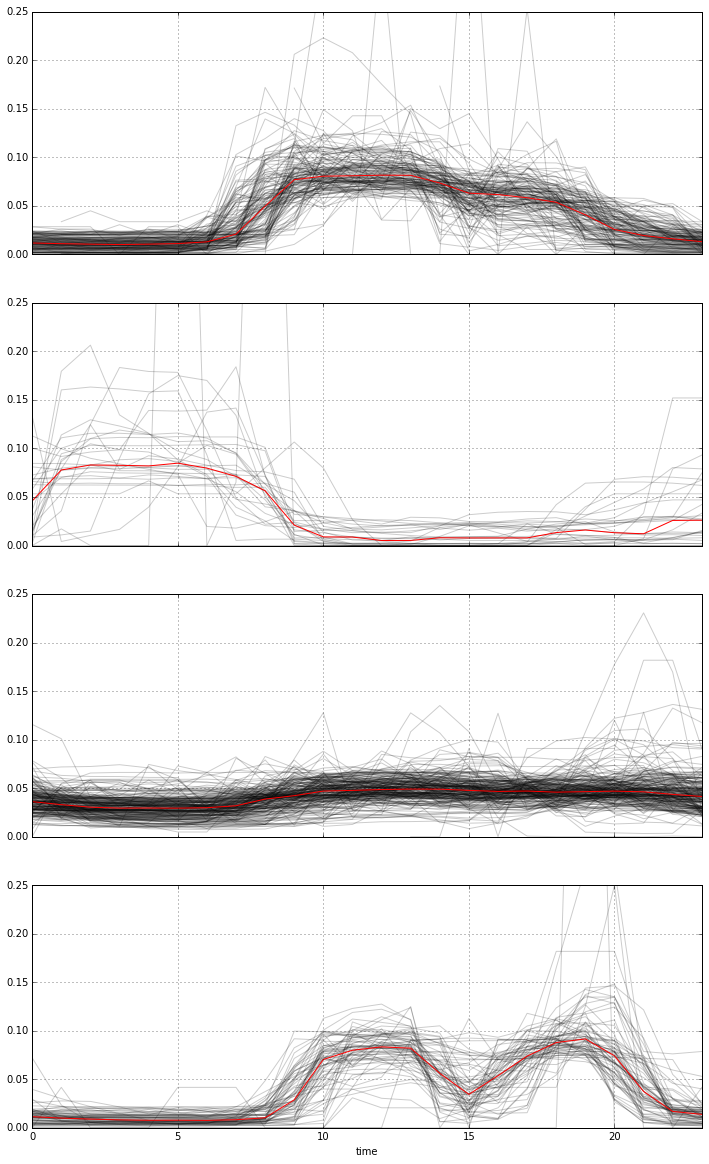

In [13]:
rlabels = np.array(rlabels) - 1  # R k-means returns labels between 1 and k 

fig, axes = plt.subplots(nrows=k, ncols=1, figsize=[12, 20])

for i in range(k):
    telemetry[rlabels == i].transpose().plot(color='k', alpha=0.2, ylim=lim, legend=False, ax=axes[i])
    telemetry[rlabels == i].median().plot(color='r', ylim=lim, ax=axes[i])

## Classification

Load data about each CUPS, and merge it with the dataframe.

In [14]:
cups = pd.read_csv('../data/cups.csv', names=['cups', 'plan', 'type'], index_col='cups')
telemetry['label'] = clt.labels_
merged = pd.merge(telemetry, cups, left_index=True, right_index=True)
merged.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,label,plan,type
cups,,,,,,,,,,,,,,,,,,,,,
ES0022000008101283SA,NaN,0.03,0.04,0.03,0.03,0.03,0.04,0.03,0.04,0.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,J
ES0031405942189001MC,NaN,0.00,0.00,0.00,0.00,NaN,0.01,0.10,0.12,0.14,...,0.01,0.01,0.01,0.01,0.00,0.00,0.00,1,3,J
ES0031405940289001JG,0.03,0.03,0.03,0.03,0.03,0.03,0.03,NaN,0.05,0.03,...,0.06,0.08,0.07,0.03,0.03,0.03,0.03,3,3,J
ES0031405248441002PD,NaN,0.00,0.00,0.00,0.00,0.00,0.02,0.07,0.08,0.08,...,0.05,0.05,0.04,0.04,0.04,0.04,0.01,1,3,J
ES0031405862959001WY,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.03,0.09,...,0.04,0.05,0.05,0.05,0.05,0.03,0.01,1,3,J


We will do classification with SVM but computing the data matrix directly using NumPy.

In [15]:
# We need a matrix X with the hour curves and a vector y with the classes
c = merged['label'].fillna('-').apply(str)
k = c.nunique()
y = c.values
X = merged[list(range(24))].fillna(0).values
c.value_counts()

3    225
1    142
0     67
2     29
dtype: int64

First split the dataset in training and test.

In [16]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print("First sample:\n{} ̣{}".format(X_train[0], y_train[0]))

First sample:
[ 0.          0.00035253  0.00035253  0.00011751  0.00117509  0.00047004
  0.04054054  0.1012926   0.09635723  0.11269095  0.10987074  0.10916569
  0.09976498  0.08942421  0.08190364  0.04300823  0.03689777  0.03795535
  0.03349001  0.00305523  0.00047004  0.00023502  0.00094007  0.00047004] ̣1


Compute the gram matrix.

In [17]:
G = np.dot(X_train, X_train.T)

In [18]:
from sklearn import svm

# Create classifier
clf = svm.SVC(kernel='precomputed', C=10)
# Fit the classifier
clf.fit(G, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='precomputed', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Predict some stuff.

In [19]:
G = np.dot(X_test, X_train.T)
y_pred = clf.predict(G)

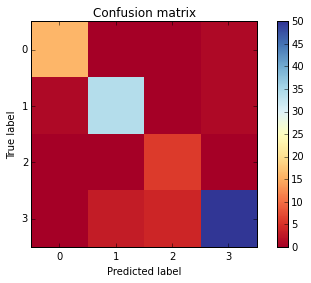

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred, y_test)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.RdYlBu)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(range(k))
plt.yticks(range(k))
plt.colorbar()
plt.tight_layout();

In [21]:
y_pred + ' → ' + y_test

array(['0 → 0', '3 → 3', '3 → 3', '1 → 1', '1 → 1', '3 → 2', '3 → 3',
       '3 → 3', '3 → 3', '1 → 1', '2 → 2', '3 → 3', '1 → 1', '3 → 3',
       '1 → 1', '3 → 1', '3 → 3', '3 → 3', '1 → 1', '1 → 1', '0 → 0',
       '3 → 3', '3 → 3', '3 → 3', '0 → 0', '1 → 1', '3 → 2', '3 → 3',
       '3 → 3', '1 → 1', '3 → 3', '1 → 1', '1 → 1', '0 → 0', '1 → 1',
       '1 → 1', '0 → 0', '0 → 0', '1 → 1', '1 → 1', '3 → 3', '3 → 1',
       '0 → 0', '1 → 1', '3 → 3', '1 → 1', '3 → 3', '3 → 3', '1 → 1',
       '3 → 3', '0 → 0', '3 → 3', '3 → 3', '3 → 3', '3 → 3', '1 → 1',
       '0 → 0', '3 → 3', '3 → 3', '1 → 1', '1 → 1', '3 → 3', '3 → 1',
       '0 → 0', '1 → 3', '3 → 3', '2 → 2', '2 → 2', '2 → 2', '1 → 1',
       '1 → 1', '1 → 1', '3 → 2', '3 → 3', '3 → 3', '1 → 1', '3 → 3',
       '1 → 1', '3 → 3', '3 → 2', '0 → 0', '1 → 1', '3 → 3', '1 → 1',
       '0 → 0', '1 → 1', '3 → 3', '2 → 2', '3 → 3', '0 → 0', '1 → 1',
       '3 → 3', '3 → 3', '1 → 0', '3 → 3', '1 → 1', '0 → 0', '3 → 3',
       '3 → 3', '0 →